# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# import gkey
from api_keys import g_key

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
lat = []
lng = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))

613


In [3]:
combined_df = pd.DataFrame({'City Name':cities})
combined_df['Latitude'] = ""
combined_df['Longitude'] = ""
combined_df['Max Temp'] = ""
combined_df['Humidity'] = ""
combined_df['Cloudiness'] = ""
combined_df['Wind Speed'] = ""
combined_df['Country'] = ""
combined_df['Date'] = ""
small_list = combined_df.head(4)
small_list

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,lanxi,,,,,,,,
1,upernavik,,,,,,,,
2,chokurdakh,,,,,,,,
3,rikitea,,,,,,,,


In [4]:
target_city = "souillac"

params = {"address": target_city, "key": g_key}

# Build URL using the Google Maps API
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

# Run request
response = requests.get(base_url, params=params)

# print the response URL, avoid doing for public GitHub repos in order to avoid exposing key
# print(response.url)

# Convert to JSON
seattle_geo = response.json()

# Extract lat/lng
lat = seattle_geo["results"][0]["geometry"]["location"]["lat"]
lng = seattle_geo["results"][0]["geometry"]["location"]["lng"]


# Print results
# print(f"{target_city}: {lat}, {lng}")
seattle_geo['results'][0]['address_components']

[{'long_name': 'Souillac',
  'short_name': 'Souillac',
  'types': ['locality', 'political']},
 {'long_name': 'Lot',
  'short_name': 'Lot',
  'types': ['administrative_area_level_2', 'political']},
 {'long_name': 'Occitanie',
  'short_name': 'Occitanie',
  'types': ['administrative_area_level_1', 'political']},
 {'long_name': 'France',
  'short_name': 'FR',
  'types': ['country', 'political']},
 {'long_name': '46200', 'short_name': '46200', 'types': ['postal_code']}]

In [5]:
params = {"key": g_key}

# Loop through the cities_pd and run a lat/long search for each city
for index, row in small_list.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    city = row['City Name']

    # update address key value
    params['address'] = f"{city}"

    # make request
    cities_lat_lng = requests.get(base_url, params=params)
    
    # convert to json
    cities_lat_lng = cities_lat_lng.json()
    
    try:
        small_list.loc[index, "Latitude"] = cities_lat_lng["results"][0]["geometry"]["location"]["lat"]
        small_list.loc[index, "Longitude"] = cities_lat_lng["results"][0]["geometry"]["location"]["lng"]
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

# Visualize to confirm lat lng appear
small_list

C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,lanxi,29.2089,119.461,,,,,,
1,upernavik,72.7863,-56.1376,,,,,,
2,chokurdakh,70.6222,147.916,,,,,,
3,rikitea,-23.1223,-134.969,,,,,,


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
url = "http://api.openweathermap.org/data/2.5/weather?"
lat = '33.7455'
lon = '-117.868'

# Build query URL
query_url = url + "appid=" + weather_api_key + "&lat=" + lat + "&lon=" + lon
weather_json = requests.get(query_url).json()
weather_json['sys']['country']

'US'

In [7]:
# params = {"key": weather_api_key}

print('Beginning Data Retrival')
print('-----------------------')

# Loop through the cities_pd and run a lat/long search for each city
for index, row in small_list.iterrows():
    
    lat = f"{row['Latitude']}"
    lon = f"{row['Longitude']}"
    
    query_url = url + "appid=" + weather_api_key + "&lat=" + lat + "&lon=" + lon

    # make request
    weather_data = requests.get(query_url)
    
    # convert to json
    weather_json = weather_data.json()
    
    counter = 0
    
    try:
        name = weather_json['name']
        print(f"Processing Record {index + 1} | {name}")
        small_list.loc[index, "Max Temp"] = weather_json['main']['temp_max']
        small_list.loc[index, "Humidity"] = weather_json['main']['humidity']
        small_list.loc[index, "Cloudiness"] = weather_json['clouds']['all']
        small_list.loc[index, "Wind Speed"] = weather_json['sys']['country']
        small_list.loc[index, "Country"] = weather_json['wind']['speed']
        small_list.loc[index, "Date"] = weather_json['dt']
        
    except (KeyError, IndexError):
        print("City not found. Skipping...")
              


# Visualize to confirm lat lng appear
print('Data Retrival Complete')
small_list

Beginning Data Retrival
-----------------------
Processing Record 1 | Lanxi


C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

Processing Record 2 | Upernavik
Processing Record 3 | Chokurdakh
Processing Record 4 | Rikitea
Data Retrival Complete


,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,lanxi,29.2089,119.461,278.9,79,100,CN,1.63,1612830409
1,upernavik,72.7863,-56.1376,264.71,76,0,GL,1.85,1612830409
2,chokurdakh,70.6222,147.916,248.23,85,0,RU,4.5,1612830409
3,rikitea,-23.1223,-134.969,298.64,69,17,PF,1.55,1612830409


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [8]:
small_list.to_csv("output_data/cities.csv")
small_list.head(4)

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,lanxi,29.2089,119.461,278.9,79,100,CN,1.63,1612830409
1,upernavik,72.7863,-56.1376,264.71,76,0,GL,1.85,1612830409
2,chokurdakh,70.6222,147.916,248.23,85,0,RU,4.5,1612830409
3,rikitea,-23.1223,-134.969,298.64,69,17,PF,1.55,1612830409


In [9]:
descr_small = small_list[['Latitude','Longitude', 'Max Temp','Humidity', 'Cloudiness', 'Wind Speed', 'Date']] .describe()

In [10]:
descr_small.to_csv("Describe_Output_Data.csv")
descr_small

,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,4.000000,4.000000,4.00,4,4,4,4
unique,4.000000,4.000000,4.00,4,3,4,1
top,70.622169,119.460526,248.23,79,0,PF,1612830409
freq,1.000000,1.000000,1.00,1,2,1,4


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [11]:
#  Get the indices of cities that have humidity over 100%.
humid_city_data = small_list.loc[small_list['Humidity'] > 100]
humid_city_data

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date


In [12]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = small_list.loc[small_list['Humidity'] <= 100]
clean_city_data

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,lanxi,29.2089,119.461,278.9,79,100,CN,1.63,1612830409
1,upernavik,72.7863,-56.1376,264.71,76,0,GL,1.85,1612830409
2,chokurdakh,70.6222,147.916,248.23,85,0,RU,4.5,1612830409
3,rikitea,-23.1223,-134.969,298.64,69,17,PF,1.55,1612830409


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [13]:
lat_v_temp = clean_city_data[['Latitude', 'Max Temp']]
lat_v_temp

,Latitude,Max Temp
0,29.2089,278.9
1,72.7863,264.71
2,70.6222,248.23
3,-23.1223,298.64


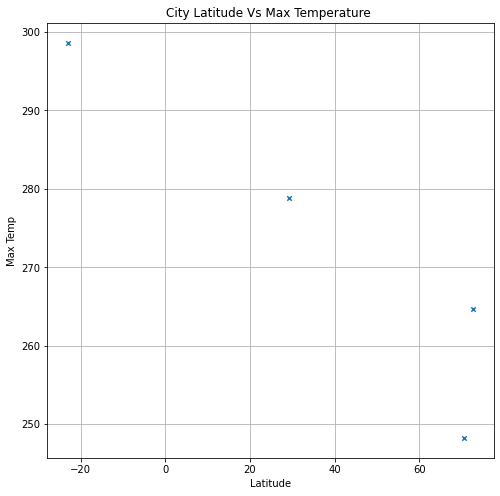

In [19]:
lat_v_temp.plot(kind="scatter", x="Latitude", y="Max Temp", grid=True, figsize=(8,8),
              title="City Latitude Vs Max Temperature ", marker='x')
plt.show()

## Latitude vs. Humidity Plot

## Latitude vs. Cloudiness Plot

## Latitude vs. Wind Speed Plot

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression